In [264]:
import lightgbm as lgb

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from coreforecast.lag_transforms import RollingMean, ExpandingStd
from sklearn.preprocessing import FunctionTransformer
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from utilsforecast.plotting import plot_series

import shap

from endogen.endogen import EndogenousSystem
from endogen.config import GlobalSimConfig, InputModel
from endogen.tools import flatten_recursive
from dataclasses import asdict
import hydra
from hydra.utils import instantiate


from utilsforecast.losses import rmse



In [265]:
# Load configuration from yaml files
with hydra.initialize(version_base = "1.3", config_path="conf"):
    config = hydra.compose(config_name = "config")
    config = instantiate(config, _convert_="all")

config.global_config
config.variables[0]

InputModel(stage='writing', output_var='grwth', input_vars=['gdppc_l1', 'grwth_rm4_l1', 'intensity_level_hlm8_l1', 'psecprop_l1'], model=MLForecast(models=[LinearRegression, RandomForestRegressor], freq=1, lag_features=[], date_features=[], num_threads=4), lags=[Lags(num_lag=1, input_vars=['gdppc', 'grwth_rm4', 'intensity_level_hlm8', 'psecprop'])], rolling=[Rolling(window=4, funs=['mean'], input_vars=['grwth'], window_type='normal'), Rolling(window=8, funs=['mean'], input_vars=['intensity_level'], window_type='halflife')], differences=[], transforms=[Transform(output_var='gdppc', input_vars=['gdppc_l1', 'grwth'], formula='np.add(gdppc_l1, gdppc_l1*grwth)', after_forecast=True)], subset=1)

In [266]:
s = EndogenousSystem(**asdict(config.global_config))
s.models.add_models(config.variables)
s.create_forecast_container()

df = s._past.to_dataframe().reset_index()
outcome = "grwth"
input_vars = [m.input_vars for m in s.models.models if m.output_var == outcome][0]
df = df.rename(columns={outcome: "y"})
df = df[flatten_recursive([["unique_id", "ds", "y"], input_vars])]
df

The following units were removed to attain a balanced dataset over 30 years: {704, 705, 520, 522, 910, 341, 343, 344, 346, 860, 620, 940, 435, 692, 53, 317}.


,unique_id,ds,y,gdppc_l1,grwth_rm4_l1,intensity_level_hlm8_l1,psecprop_l1
0,2,1999,0.046437,46983.310736,0.037718,0.000000,0.296919
1,2,2000,0.040446,48653.328112,0.042705,0.000000,0.299292
2,2,2001,0.009934,50100.290300,0.043558,0.000000,0.301665
3,2,2002,0.017267,50102.495291,0.035164,0.270148,0.303650
4,2,2003,0.028210,50505.025477,0.028521,0.363852,0.305634
...,...,...,...,...,...,...,...
3330,950,2017,0.027025,12086.768495,0.042105,0.000000,0.183058
3331,950,2018,0.050973,12409.115471,0.037297,0.000000,0.187135
3332,950,2019,0.003610,13058.372232,0.035786,0.000000,0.191211
3333,950,2020,-0.186332,13113.177089,0.028890,0.000000,0.195287


In [267]:
test_years = 10
train = df[df["ds"] <= gc.start - test_years]
test = df[df["ds"] > gc.start - test_years]


In [268]:
mlf = MLForecast(
    models = [LinearRegression()],
    freq = 1
)

mlf.fit(train, static_features = input_vars, prediction_intervals=PredictionIntervals(n_windows = 4, h = 1))
levels = [50, 80, 95]
predictions = mlf.predict(test_years, level = levels)
#predictions

Prediction intervals are calculated using 1-step ahead cross-validation, with a constant width for all horizons. To vary the error by horizon, pass PredictionIntervals(h=h) to the `prediction_intervals` argument when refitting the model.


In [247]:
mlf.models_['LinearRegression'].intercept_, mlf.models_['LinearRegression'].coef_

(0.02924191006479024,
 array([-1.15156888e-07,  3.88735046e-01,  8.63352900e-03, -2.65824047e-02]))

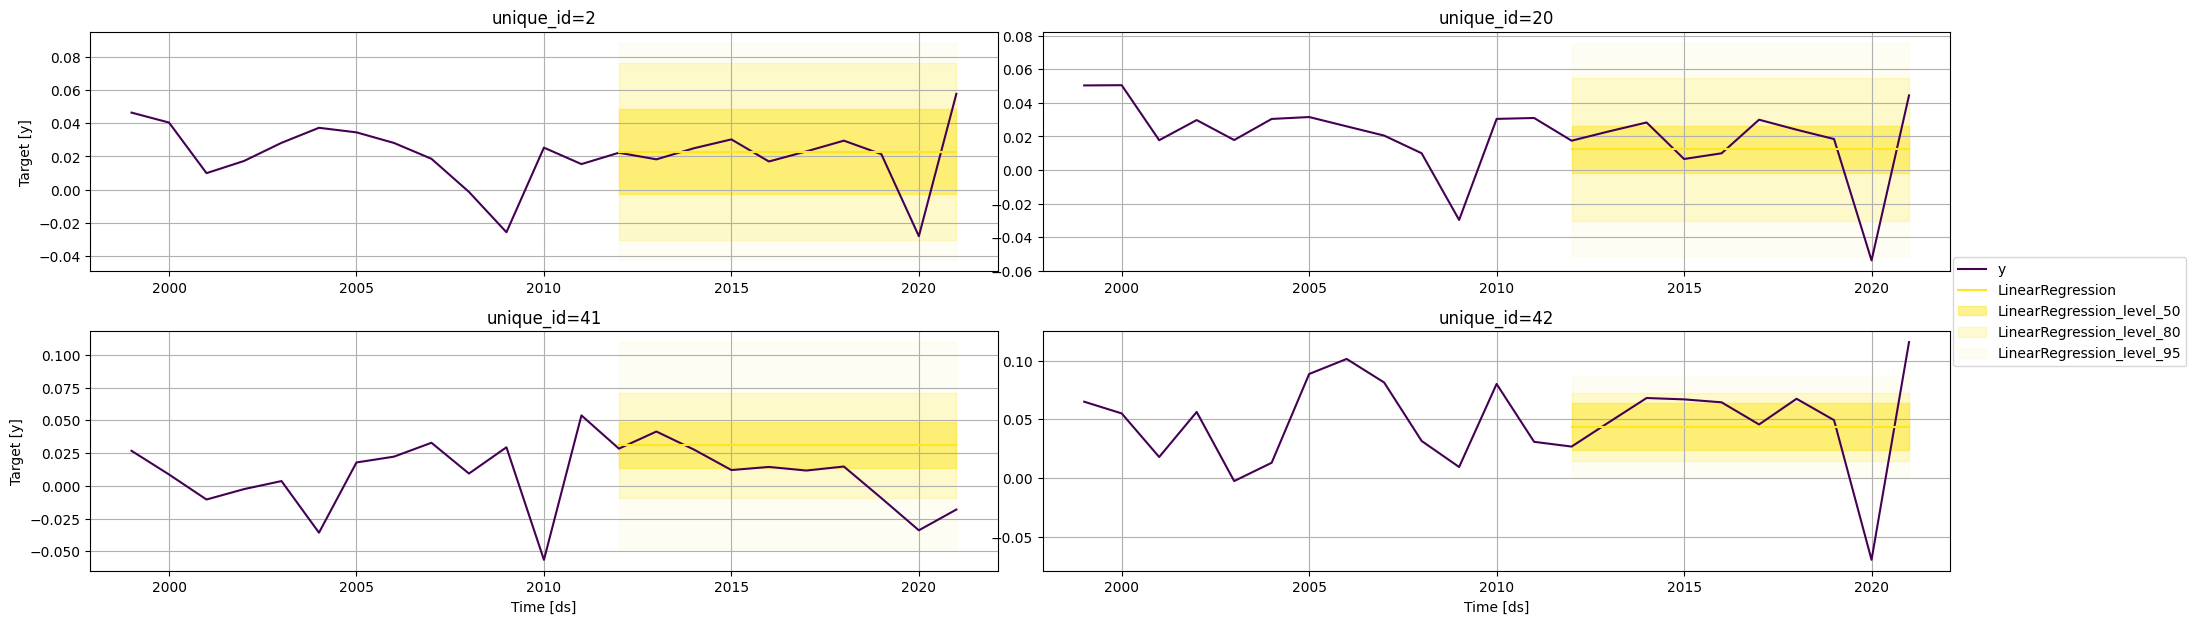

In [269]:
plot_series(pd.concat([train, test]), predictions, max_ids=4, plot_random=False, level = levels)

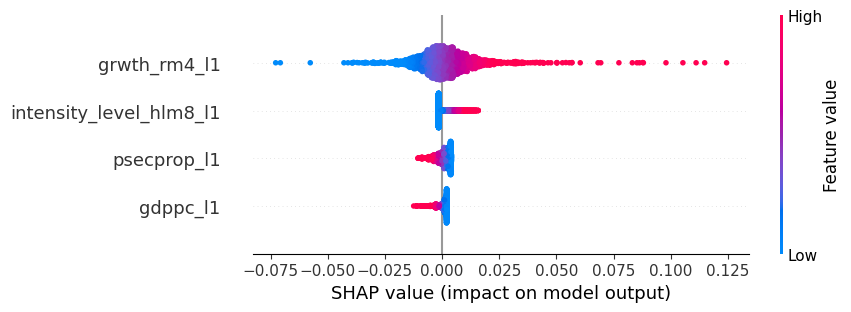

In [249]:
X = mlf.preprocess(train)
X = X.drop(columns=['unique_id', 'ds', 'y'])

X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(mlf.models_['LinearRegression'].predict, X100)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values)

In [251]:
crossvalidation_df = mlf.cross_validation(
    df=train,
    h=3,
    n_windows=3,
)

Excuting `cross_validation` after `fit` can produce unexpected errors


In [252]:
crossvalidation_df['id_cutoff'] = crossvalidation_df['unique_id'].astype(str) + '_' + crossvalidation_df['cutoff'].astype(str)
crossvalidation_df

,unique_id,ds,cutoff,y,LinearRegression,id_cutoff
0,2,2003,2002,0.028210,0.032514,2_2002
1,2,2004,2002,0.037285,0.032514,2_2002
2,2,2005,2002,0.034529,0.032514,2_2002
3,20,2003,2002,0.017855,0.035177,20_2002
4,20,2004,2002,0.030403,0.035177,20_2002
...,...,...,...,...,...,...
430,920,2010,2008,0.009576,0.036683,920_2008
431,920,2011,2008,0.026601,0.036683,920_2008
432,950,2009,2008,-0.014099,0.033237,950_2008
433,950,2010,2008,0.029559,0.033237,950_2008


In [253]:

models = ['LinearRegression']
cv_rmse = rmse(crossvalidation_df, models=models, id_col='id_cutoff')
cv_rmse[models].mean()

LinearRegression    0.036432
dtype: float64